# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

Data Exploration

1. portfolio data

In [3]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
portfolio.shape

(10, 6)

The channel column consists of list in each row. Instead, I would like to convert the list variable into dummy/indicator variables by expanding the columns.

In [5]:
#split the channels into 4 columns - web, email, mobile, social
portfolio1 = portfolio .join(portfolio ['channels'].str.join('|').str.get_dummies())


In [6]:
portfolio1

,reward,channels,difficulty,duration,offer_type,id,email,mobile,social,web
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


2. profile data

In [7]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [8]:
profile.shape

(17000, 5)

In [9]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [10]:
#check null values in the data frame
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

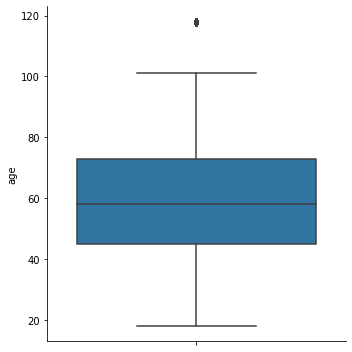

In [11]:
#check outliers in the age field by using seaborn boxplot
sns.catplot(y='age', data=profile, kind='box')
plt.show()
#The plot clearly shows the outlier is above 100 level. Also in reality, an age bigger than 100 year old is not usual to see.

In [12]:
#count the number of the age bigger than 100 year old

profile[profile['age'] > 100]['age'].count()

2180

From the missing value analysis there are 2175 rows of null values on gender and income fields. It is highly possible those who didn't fill out the gender information left the incomde information blank as well. From the box plot, we can see outliers of age is bigger than 100-year-old which does not make any sense. Coincidently the number of rows that are having age larger than 100 is 2180 which is very close to the number of missing values on gender and income fields. One possible explanation is those who didn't fill out the gender information left the age information blank which is set to the default value of 118. So I decide to drop rows of missing gender and income values and hopefully can exclude the noisy age values.

In [13]:
#drop null values in the profile dataframe
profile1 = profile.dropna(subset=['gender']).reset_index(drop=True)
profile1.head()

,gender,age,id,became_member_on,income
0,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
2,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
3,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0


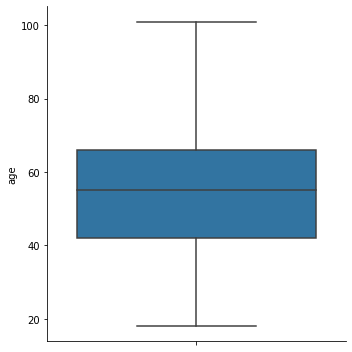

In [14]:
#replot the age field in the cleaned profile dataframe
sns.catplot(y='age', data=profile1, kind='box')
plt.show()

After droping null values in the profile dataframe, it looks much clean and more helpful to the analysis in the following steps.

In [15]:
#check total types of gender
profile1.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

Since gender of 'O' is having a tiny amount of customers comparing to the other two gender groups, I have decided to drop this gender group.

In [16]:
profile1 = profile1[profile1['gender'] != 'O']

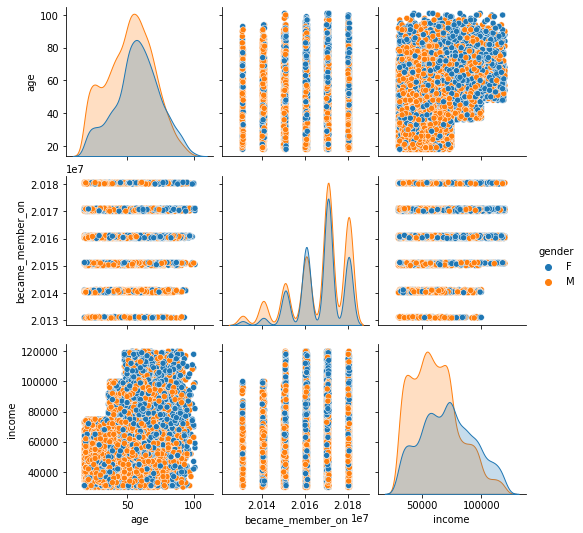

In [17]:
#use seaborn to show statistical distribution of age, membership since year, and income over different genders
sns.pairplot(profile1,hue='gender')

3. transcript data

In [18]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [19]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


Similar to the channel field in the portfolio dataframe, the value field in the transcript dataframe consists of dictionary elements.  I would like to separate the key/values pair in the dictionary to be new columns with each key as the column name and values to be filled in the columns accordingly. 

In [20]:
#define a function to separate the key/value pairs to be the new columns in the dataframe
def formatting_col(col, df):
    '''
    returns a dataframe that separate the key/value pairs in the sepecific column and save the values in the new columns with key as the new column name
    
    INPUT:
    df - the input dataframe
    col - column name in the dataframe
    
    OUTPUT:
    df - a new dataframe that separate the key/value pairs in the col and save the values in the new columns with key as the new column name

    
    ''' 
    df1 = pd.DataFrame(list(df[col]))
    df = df.drop(col,axis=1)
    df = pd.concat([df, df1], axis=1)
    return df

In [21]:
#separating the dictionary values in the value column
transcript1 = formatting_col('value', transcript)

After cleaning the value field, three new columns are created:'offer id', 'offer_id', 'amount'. 'offer id' and 'offer_id' are identical and contain the same information. It is reasonable to combine these two into one unique column.

In [22]:
#combine 'offer id' and 'offer_id' columns into 'offer_id' column.
transcript1['offer_id'] = np.where(transcript1['offer_id'].isnull(), transcript1['offer id'], transcript1['offer_id'])
transcript1 = transcript1.drop('offer id',axis=1)

In [23]:
transcript1

,person,event,time,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,1.59,NaN,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,9.53,NaN,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,3.61,NaN,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,3.53,NaN,NaN


In [24]:
#rearrange the order of the dataframe by person ids and time
transcript1=transcript1.sort_values(['person','time']).reset_index(drop=True)


In [25]:
transcript1.shape

(306534, 6)

In [26]:
#extract transaction information into a new transaction dataframe
transaction = transcript1[transcript1['event'] == 'transaction']


In [27]:
transaction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138953 entries, 2 to 306533
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   person    138953 non-null  object 
 1   event     138953 non-null  object 
 2   time      138953 non-null  int64  
 3   amount    138953 non-null  float64
 4   offer_id  0 non-null       object 
 5   reward    0 non-null       float64
dtypes: float64(2), int64(1), object(3)
memory usage: 7.4+ MB


From the portfolio dataframe, we know there are three types of offer: BOGO, Discount and informational. I have a couple of interesting observation on the offer types:
-Informational offer does not need a minimum spending amount to complete the offer, and there is no 'offer complete' status for the informational offer. Also no reward for the informational offer.
-BOGO and Discount offer both need a minimum spending amount to complete the offer which can be called as transactional offer. If the customer spent the minimum amount within the allowable time period, a 'offer complete' status would show up with a record of reward amount awarded to the customer.
Based on those observation, I decide to treat informational offer different from the BOGO/Discount offer.

In [28]:
#create an informational offer id list from the portfolio dataframe
portfoilo_info_offer = portfolio[portfolio['offer_type']=='informational']
infor_offer_list = list(portfoilo_info_offer['id'])
infor_offer_list

['3f207df678b143eea3cee63160fa8bed', '5a8bc65990b245e5a138643cd4eb9837']

In [29]:
#extract infromational offers from the cleaned transcript dataframe
infor_offer = transcript1[transcript1['offer_id'].isin(infor_offer_list)].copy()

In [30]:
infor_offer.head()

,person,event,time,amount,offer_id,reward
0,0009655768c64bdeb2e877511632db8f,offer received,168,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN
1,0009655768c64bdeb2e877511632db8f,offer viewed,192,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN
3,0009655768c64bdeb2e877511632db8f,offer received,336,NaN,3f207df678b143eea3cee63160fa8bed,NaN
4,0009655768c64bdeb2e877511632db8f,offer viewed,372,NaN,3f207df678b143eea3cee63160fa8bed,NaN
27,0011e0d4e6b944f998e987f904e8c1e5,offer received,0,NaN,3f207df678b143eea3cee63160fa8bed,NaN


One of the key characteristics to the informational offer is it does not need to make a minimum transaction to complete the offer. Since the offer is informational, 
as long as the customers viewed the offer in the allowed time duration can be treated as 'successful offer'.
Therefore, the standard workflow for the successful informational offer is:
'offer received' -> 'offer viewed'
The filter criteria for the successful informational offer are:
1. 'offer viewed' status row following 'offer received'
2. 'offer viewed' time is within the reuqired time duration
Any offer is treated as a successful offer(rating 2). Any offer not completed is called as 'unsuccessful offer' (rating 0).

In [31]:
# find the duration for the informational offers
infor_offer_duration = dict(zip(portfoilo_info_offer['id'], portfoilo_info_offer['duration']))
# calculate the time of 'offer_viewed'
infor_offer['duration'] = infor_offer['offer_id'].map(infor_offer_duration)
infor_offer['offer_end'] = infor_offer['time'] + infor_offer['duration'] * 24
infor_offer['offer_end'] = infor_offer.groupby(['person'])['offer_end'].ffill()
infor_offer['time_remaining'] = infor_offer['offer_end']-infor_offer['time']
#create the previous offer status for each 'offer viewed' status row
infor_offer['previous_event'] = infor_offer.groupby(['person','offer_id'])['event'].shift()

In [32]:
infor_offer.head()

,person,event,time,amount,offer_id,reward,duration,offer_end,time_remaining,previous_event
0,0009655768c64bdeb2e877511632db8f,offer received,168,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,3,240,72,NaN
1,0009655768c64bdeb2e877511632db8f,offer viewed,192,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,3,264,72,offer received
3,0009655768c64bdeb2e877511632db8f,offer received,336,NaN,3f207df678b143eea3cee63160fa8bed,NaN,4,432,96,NaN
4,0009655768c64bdeb2e877511632db8f,offer viewed,372,NaN,3f207df678b143eea3cee63160fa8bed,NaN,4,468,96,offer received
27,0011e0d4e6b944f998e987f904e8c1e5,offer received,0,NaN,3f207df678b143eea3cee63160fa8bed,NaN,4,96,96,NaN


In [33]:
# Use the filter criteria for the successful informational offer to mark successful offer with 2 and unsuccesful offer with 0
infor_offer['success_rating'] = np.where((infor_offer['event'] == 'offer viewed')&(infor_offer['time_remaining'] > 0)&(infor_offer['previous_event'] == 'offer received'), 2, np.nan)
infor_offer['success_rating'] = infor_offer.groupby(['person', 'offer_id'])['success_rating'].bfill()
infor_received_rev = infor_offer[infor_offer['event']=='offer received'].copy()
infor_received_rev['success_rating'] = infor_received_rev['success_rating'].fillna(0)

In [34]:
infor_received_rev

,person,event,time,amount,offer_id,reward,duration,offer_end,time_remaining,previous_event,success_rating
0,0009655768c64bdeb2e877511632db8f,offer received,168,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,3,240,72,NaN,2.0
3,0009655768c64bdeb2e877511632db8f,offer received,336,NaN,3f207df678b143eea3cee63160fa8bed,NaN,4,432,96,NaN,2.0
27,0011e0d4e6b944f998e987f904e8c1e5,offer received,0,NaN,3f207df678b143eea3cee63160fa8bed,NaN,4,96,96,NaN,2.0
34,0011e0d4e6b944f998e987f904e8c1e5,offer received,336,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,3,408,72,NaN,2.0
56,0020c2b971eb4e9188eac86d93036a77,offer received,504,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,3,576,72,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...
306395,fff0f0aac6c547b9b263080f09a5586a,offer received,576,NaN,3f207df678b143eea3cee63160fa8bed,NaN,4,672,96,offer viewed,2.0
306441,fff3ba4757bd42088c044ca26d73817a,offer received,336,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,3,408,72,NaN,2.0
306443,fff3ba4757bd42088c044ca26d73817a,offer received,504,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,3,576,72,offer received,2.0
306474,fff8957ea8b240a6b5e634b6ee8eafcf,offer received,504,NaN,3f207df678b143eea3cee63160fa8bed,NaN,4,600,96,NaN,0.0


For BOGO/Discount offer, it is more complicated than cleaning the informational offer. The customers need to make the minimum purchase within the required time duration after receiving the offer to complete the offer and obtain the reward. However there is one critical thing to note: among the successful offers, customers can receive an offer, never actually view the offer, and still complete the offer. This should be differentiated which may lead bias in the real successful offers, which is called as 'noview successful offer'.
Therefore, the standard workflow for the successful transactional offer is:
'offer received' -> 'offer viewed' -> 'transaction' -> 'offer completed'
The filter criteria for the successful informational offer are:
1. 'offer viewed' status row following 'offer received'
2. 'offer completed' time is within the reuqired time duration
3. make the minimum required transaction.
After looking further into the criteria, I realize the second and third criteria are not needed since if one of them is not achieved there won't be showing 'offer completed' with reward awarded event happen. So the primary focus is the order of 'offer viewed' and 'order completed'. As long as 'order completed' is not ahead of the 'order viewed', the offer can be treated as a successful offer(rating 2). Otherwise it is treated as unviewed successful offer(rating 1). Any offer not completed is called as 'unsuccessful offer' (rating 0).

In [35]:
#extract all offer related events into offer dataframe
offer = transcript1[transcript1['event'] != 'transaction'].copy()
offer = offer[~offer['offer_id'].isin(infor_offer_list)]
offer.head()

,person,event,time,amount,offer_id,reward
5,0009655768c64bdeb2e877511632db8f,offer received,408,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN
7,0009655768c64bdeb2e877511632db8f,offer completed,414,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0
8,0009655768c64bdeb2e877511632db8f,offer viewed,456,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN
9,0009655768c64bdeb2e877511632db8f,offer received,504,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
11,0009655768c64bdeb2e877511632db8f,offer completed,528,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0


In [36]:
#create a new column 'previous_event' for the filtering use in the following steps
offer['previous_event'] = offer.groupby(['person','offer_id'])['event'].shift()

In [37]:
#extract offer_received events and offer_completed events into two separate dataframes
offer_received = offer[offer['event']=='offer received'].copy()
offer_completed = offer[offer['event']=='offer completed'].copy()

In [38]:
offer_completed

,person,event,time,amount,offer_id,reward,previous_event
7,0009655768c64bdeb2e877511632db8f,offer completed,414,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0,offer received
11,0009655768c64bdeb2e877511632db8f,offer completed,528,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0,offer received
16,0009655768c64bdeb2e877511632db8f,offer completed,576,NaN,2906b810c7d4411798c6938adc9daaa5,2.0,offer received
33,0011e0d4e6b944f998e987f904e8c1e5,offer completed,252,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0,offer viewed
41,0011e0d4e6b944f998e987f904e8c1e5,offer completed,576,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,offer viewed
...,...,...,...,...,...,...,...
306510,ffff82501cea40309d5fdd7edcca4a07,offer completed,198,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,offer viewed
306518,ffff82501cea40309d5fdd7edcca4a07,offer completed,384,NaN,2906b810c7d4411798c6938adc9daaa5,2.0,offer viewed
306522,ffff82501cea40309d5fdd7edcca4a07,offer completed,414,NaN,2906b810c7d4411798c6938adc9daaa5,2.0,offer viewed
306526,ffff82501cea40309d5fdd7edcca4a07,offer completed,504,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,offer received


In [39]:
#find successful offers if offer_completed is after the offer_viewed
offer_completed['success_offer'] = np.where(offer_completed['previous_event'] == 'offer viewed', 2, 0)

In [40]:
#find unviewed successful offers if offer_completed is ahead of the offer_viewed
offer_completed['noview_success_offer'] = np.where(offer_completed['previous_event'] != 'offer viewed', 1, 0)

In [41]:
#combine both ratings into one field
offer_completed['success_rating'] = offer_completed['success_offer'] + offer_completed['noview_success_offer']

In [42]:
#clean up the dataframe
offer_completed = offer_completed.drop(columns=['previous_event', 'success_offer', 'noview_success_offer'])

In [43]:
offer_completed.head()

,person,event,time,amount,offer_id,reward,success_rating
7,0009655768c64bdeb2e877511632db8f,offer completed,414,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0,1
11,0009655768c64bdeb2e877511632db8f,offer completed,528,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0,1
16,0009655768c64bdeb2e877511632db8f,offer completed,576,NaN,2906b810c7d4411798c6938adc9daaa5,2.0,1
33,0011e0d4e6b944f998e987f904e8c1e5,offer completed,252,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0,2
41,0011e0d4e6b944f998e987f904e8c1e5,offer completed,576,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,2


In [44]:
#transfer the ratings from offer_completed dataframe into offer_received dataframe
df_offer = pd.concat([offer_completed,offer_received], axis=0).sort_values(['person', 'time'])
df_offer['success_rating'] = df_offer.groupby(['person', 'offer_id'])['success_rating'].bfill()
#rate all unsuccessful offers as 0
df_offer['success_rating'] = df_offer['success_rating'].fillna(0)
df_offer = df_offer.drop(columns='previous_event')

In [45]:
#trim the dataframe to keep offer_received events only
offer_received_rev = df_offer[df_offer['event']=='offer received']

In [46]:
offer_received_rev.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61042 entries, 5 to 306528
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   person          61042 non-null  object 
 1   event           61042 non-null  object 
 2   time            61042 non-null  int64  
 3   amount          0 non-null      float64
 4   offer_id        61042 non-null  object 
 5   reward          0 non-null      float64
 6   success_rating  61042 non-null  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 3.7+ MB


In [47]:
#combine cleaned informational offer dataframe with cleaned transactional offer dataframe
offer_received_combine = pd.concat([infor_received_rev,offer_received_rev],axis=0).sort_values(['person','time']).reset_index()
offer_received_combine = offer_received_combine.drop(['reward', 'duration','time_remaining', 'amount', 'offer_end', 'previous_event'], axis=1)
offer_received_combine

,index,person,event,time,offer_id,success_rating
0,0,0009655768c64bdeb2e877511632db8f,offer received,168,5a8bc65990b245e5a138643cd4eb9837,2.0
1,3,0009655768c64bdeb2e877511632db8f,offer received,336,3f207df678b143eea3cee63160fa8bed,2.0
2,5,0009655768c64bdeb2e877511632db8f,offer received,408,f19421c1d4aa40978ebb69ca19b0e20d,1.0
3,9,0009655768c64bdeb2e877511632db8f,offer received,504,fafdcd668e3743c1bb461111dcafc2a4,1.0
4,14,0009655768c64bdeb2e877511632db8f,offer received,576,2906b810c7d4411798c6938adc9daaa5,0.0
...,...,...,...,...,...,...
76272,306507,ffff82501cea40309d5fdd7edcca4a07,offer received,168,0b1e1539f2cc45b7b9fa7c272da2e1d7,2.0
76273,306515,ffff82501cea40309d5fdd7edcca4a07,offer received,336,2906b810c7d4411798c6938adc9daaa5,2.0
76274,306519,ffff82501cea40309d5fdd7edcca4a07,offer received,408,2906b810c7d4411798c6938adc9daaa5,2.0
76275,306524,ffff82501cea40309d5fdd7edcca4a07,offer received,504,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0


After rating all offers, the next step is to calculate transaction amounts to each offer and pass to the rating dataframe.
In order to determine if a transaction is a valid transaction to a specific offer is if the transaction happens within the time duration.
Then the following step is to sum the transaction to each offer and pass to the cleaned offer_received dataframe.

In [48]:
#merge offer_received dataframe with portfolio1 dataframe
df_offer_received = offer_received_combine.merge(portfolio1, left_on='offer_id', right_on='id', how='left')
#use the duration field to calculate the offer ending time
df_offer_received['offer_end'] = df_offer_received['time'] + df_offer_received['duration'] * 24
#merge transaction dataframe
df_transaction = pd.concat([df_offer_received, transaction], axis=0).sort_values(['person','time'])
#pass the offer end time to all transaction rows
df_transaction['offer_end'] = df_transaction.groupby(['person'])['offer_end'].ffill()
df_transaction['index'] = df_transaction.groupby(['person'])['index'].ffill()
#calculate the remaining time for each transaction, if the remaining time is greater than zero then the transaction is valid
df_transaction['time_remaining'] = df_transaction['offer_end']-df_transaction['time']
df_transaction = df_transaction[df_transaction['time_remaining']>= 0]
#sum valid transactions to each offer
transaction_sum = df_transaction .groupby(['person','index'])['amount'].sum().reset_index()

In [49]:
transaction_sum 

,person,index,amount
0,0009655768c64bdeb2e877511632db8f,0.0,22.16
1,0009655768c64bdeb2e877511632db8f,3.0,0.00
2,0009655768c64bdeb2e877511632db8f,5.0,8.57
3,0009655768c64bdeb2e877511632db8f,9.0,27.67
4,0009655768c64bdeb2e877511632db8f,14.0,69.20
...,...,...,...
76272,ffff82501cea40309d5fdd7edcca4a07,306507.0,96.37
76273,ffff82501cea40309d5fdd7edcca4a07,306515.0,15.57
76274,ffff82501cea40309d5fdd7edcca4a07,306519.0,30.72
76275,ffff82501cea40309d5fdd7edcca4a07,306524.0,7.79


With two major cleaning steps ( filtering successful offer and calculating transaction amount to each offer) done. The final step is to combine all information into a clean dataframe.

In [50]:
#offer_received dataframe merging with the calculated transaction dataframe
offer_received_transaction_combine = offer_received_combine.merge(transaction_sum, on=['person','index'])
offer_received_transaction_combine

,index,person,event,time,offer_id,success_rating,amount
0,0,0009655768c64bdeb2e877511632db8f,offer received,168,5a8bc65990b245e5a138643cd4eb9837,2.0,22.16
1,3,0009655768c64bdeb2e877511632db8f,offer received,336,3f207df678b143eea3cee63160fa8bed,2.0,0.00
2,5,0009655768c64bdeb2e877511632db8f,offer received,408,f19421c1d4aa40978ebb69ca19b0e20d,1.0,8.57
3,9,0009655768c64bdeb2e877511632db8f,offer received,504,fafdcd668e3743c1bb461111dcafc2a4,1.0,27.67
4,14,0009655768c64bdeb2e877511632db8f,offer received,576,2906b810c7d4411798c6938adc9daaa5,0.0,69.20
...,...,...,...,...,...,...,...
76272,306507,ffff82501cea40309d5fdd7edcca4a07,offer received,168,0b1e1539f2cc45b7b9fa7c272da2e1d7,2.0,96.37
76273,306515,ffff82501cea40309d5fdd7edcca4a07,offer received,336,2906b810c7d4411798c6938adc9daaa5,2.0,15.57
76274,306519,ffff82501cea40309d5fdd7edcca4a07,offer received,408,2906b810c7d4411798c6938adc9daaa5,2.0,30.72
76275,306524,ffff82501cea40309d5fdd7edcca4a07,offer received,504,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,7.79


In [51]:
#merge portfolio1 dataframe into the combined dataframe
df = offer_received_transaction_combine.merge(portfolio1, left_on='offer_id', right_on='id')
df = df.merge(profile1, left_on='person', right_on='id', how='inner')


In [52]:
#clearning columns
df=df.drop(['event', 'id_x','id_y','channels'], axis=1)
df = df.rename(columns={'amount': 'transaction amount'})

In [53]:
df.head(5)

,index,person,time,offer_id,success_rating,transaction amount,reward,difficulty,duration,offer_type,email,mobile,social,web,gender,age,became_member_on,income
0,0,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,2.0,22.16,0,0,3,informational,1,1,1,0,M,33,20170421,72000.0
1,3,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed,2.0,0.00,0,0,4,informational,1,1,0,1,M,33,20170421,72000.0
2,5,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,1.0,8.57,5,5,5,bogo,1,1,1,1,M,33,20170421,72000.0
3,9,0009655768c64bdeb2e877511632db8f,504,fafdcd668e3743c1bb461111dcafc2a4,1.0,27.67,2,10,10,discount,1,1,1,1,M,33,20170421,72000.0
4,14,0009655768c64bdeb2e877511632db8f,576,2906b810c7d4411798c6938adc9daaa5,0.0,69.20,2,10,7,discount,1,1,0,1,M,33,20170421,72000.0


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65585 entries, 0 to 65584
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               65585 non-null  int64  
 1   person              65585 non-null  object 
 2   time                65585 non-null  int64  
 3   offer_id            65585 non-null  object 
 4   success_rating      65585 non-null  float64
 5   transaction amount  65585 non-null  float64
 6   reward              65585 non-null  int64  
 7   difficulty          65585 non-null  int64  
 8   duration            65585 non-null  int64  
 9   offer_type          65585 non-null  object 
 10  email               65585 non-null  int64  
 11  mobile              65585 non-null  int64  
 12  social              65585 non-null  int64  
 13  web                 65585 non-null  int64  
 14  gender              65585 non-null  object 
 15  age                 65585 non-null  int64  
 16  beca

Exploratory Data Analysis

1. Which offer is the most popular one in each gender group?

In [55]:
#extract successful offers into a separate datafram for analysis use
successfull_offer = df[df['success_rating'] == 2.0].reset_index(drop=True)
#extract unsuccessful offers into a separate datafram for analysis use
unsuccessfull_offer = df[df['success_rating'] == 1.0].reset_index(drop=True)

In [56]:
successfull_offer

,index,person,time,offer_id,success_rating,transaction amount,reward,difficulty,duration,offer_type,email,mobile,social,web,gender,age,became_member_on,income
0,0,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,2.0,22.16,0,0,3,informational,1,1,1,0,M,33,20170421,72000.0
1,3,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed,2.0,0.00,0,0,4,informational,1,1,0,1,M,33,20170421,72000.0
2,56,0020c2b971eb4e9188eac86d93036a77,504,5a8bc65990b245e5a138643cd4eb9837,2.0,51.10,0,0,3,informational,1,1,1,0,F,59,20160304,90000.0
3,45,0020c2b971eb4e9188eac86d93036a77,0,fafdcd668e3743c1bb461111dcafc2a4,2.0,98.33,2,10,10,discount,1,1,1,1,F,59,20160304,90000.0
4,54,0020c2b971eb4e9188eac86d93036a77,408,4d5c57ea9a6940dd891ad53e9dbe8da0,2.0,0.00,10,10,5,bogo,1,1,1,1,F,59,20160304,90000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31882,220055,b6d81a7cd7154f7d8155b3351fb514cd,408,4d5c57ea9a6940dd891ad53e9dbe8da0,2.0,53.54,10,10,5,bogo,1,1,1,1,M,53,20171122,111000.0
31883,279260,e8aff9960beb45d784bfe145f960581d,0,4d5c57ea9a6940dd891ad53e9dbe8da0,2.0,22.02,10,10,5,bogo,1,1,1,1,F,89,20171013,103000.0
31884,292864,f47051cad4844338be9332c33ddba9ef,0,4d5c57ea9a6940dd891ad53e9dbe8da0,2.0,33.10,10,10,5,bogo,1,1,1,1,M,88,20160730,111000.0
31885,292869,f47051cad4844338be9332c33ddba9ef,336,4d5c57ea9a6940dd891ad53e9dbe8da0,2.0,869.02,10,10,5,bogo,1,1,1,1,M,88,20160730,111000.0


In [57]:
unsuccessfull_offer

,index,person,time,offer_id,success_rating,transaction amount,reward,difficulty,duration,offer_type,email,mobile,social,web,gender,age,became_member_on,income
0,5,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,1.0,8.57,5,5,5,bogo,1,1,1,1,M,33,20170421,72000.0
1,9,0009655768c64bdeb2e877511632db8f,504,fafdcd668e3743c1bb461111dcafc2a4,1.0,27.67,2,10,10,discount,1,1,1,1,M,33,20170421,72000.0
2,53,0020c2b971eb4e9188eac86d93036a77,336,fafdcd668e3743c1bb461111dcafc2a4,1.0,0.00,2,10,10,discount,1,1,1,1,F,59,20160304,90000.0
3,108,003d66b6608740288d6cc97a6903f4f0,504,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,20.95,5,20,10,discount,1,0,0,1,F,26,20170621,73000.0
4,273,0082fd87c18f45f2be70dbcbb0fb8aad,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,8.95,5,5,7,bogo,1,1,0,1,F,28,20170908,68000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8948,193023,a06ea635b65d4c24a3ca5a6324f23067,408,ae264e3637204a6fb9bb56bc8210ddfd,1.0,25.59,10,10,7,bogo,1,1,1,0,F,83,20171112,95000.0
8949,250688,d10314cc85374d27a116c0472bdde459,168,ae264e3637204a6fb9bb56bc8210ddfd,1.0,96.47,10,10,7,bogo,1,1,1,0,F,56,20150914,92000.0
8950,294625,f5de20984950433d9c206f7c42477342,408,ae264e3637204a6fb9bb56bc8210ddfd,1.0,154.00,10,10,7,bogo,1,1,1,0,M,48,20150910,75000.0
8951,157951,842d5869a6764e1f9582470653fde953,0,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,0.00,10,10,5,bogo,1,1,1,1,F,82,20150821,65000.0


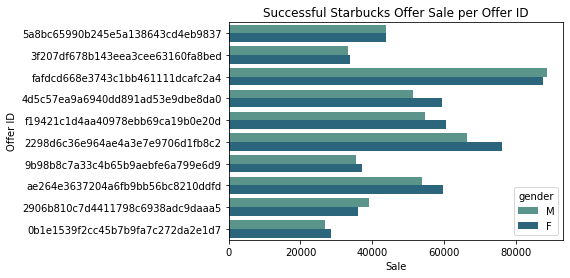

In [58]:
sns.barplot(y='offer_id',x='transaction amount',data=successfull_offer,estimator=sum, ci=None, hue='gender', palette='crest')
plt.title('Successful Starbucks Offer Sale per Offer ID')
plt.xlabel('Sale')
plt.ylabel('Offer ID')
plt.show()

The plot shows the most successful offer is offer id: fafdcd668e3743c1bb461111dcafc2a4. And male customers are making slightly more transaction than female customers. And the second most successful offer is offer id: f2298d6c36e964ae4a3e7e9706d1fb8c2 which is more popular in female customers.

2. Which offer type is the most successful one? And explore gender preferrence in the offer type.

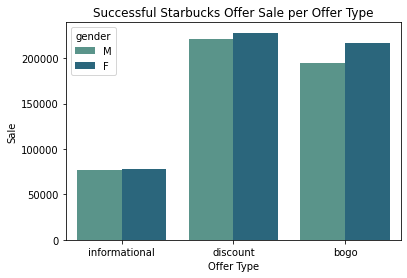

In [59]:
sns.barplot(x='offer_type',y='transaction amount',data=successfull_offer,estimator=sum, ci=None, hue='gender', palette='crest')
plt.title('Successful Starbucks Offer Sale per Offer Type')
plt.xlabel('Offer Type')
plt.ylabel('Sale')
#plt.savefig('Airbnb listing booked days in Seattle versus Month.png')
plt.show()

The plot shows the duscount offer type is most popular offer type in all genders. Overall, more female customers are using promotions than male customers.

3. Which age group spends most on starbucks?

In [60]:
#classified all customers into different age groups
bins= [0, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
labels = ['0-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100', '100+']
successfull_offer['age_group'] = pd.cut(successfull_offer['age'], bins=bins, labels=labels, right=False)

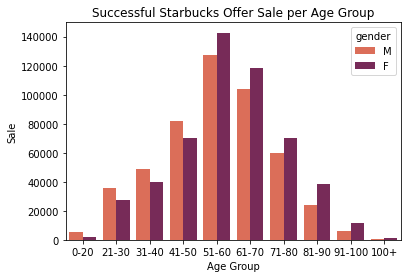

In [61]:
sns.barplot(x='age_group',y='transaction amount',data=successfull_offer,estimator=sum, ci=None, hue='gender', palette='rocket_r')
plt.title('Successful Starbucks Offer Sale per Age Group')
plt.xlabel('Age Group')
plt.ylabel('Sale')
plt.show()

It can be read from the plot that age group of 51-60 consumes most on starbucks in all age groups, and 61-70 age group is next. The overall trend is telling us starbucks is more popular in female customers that are more than 50 year old.

4. Income distribution by Gender.

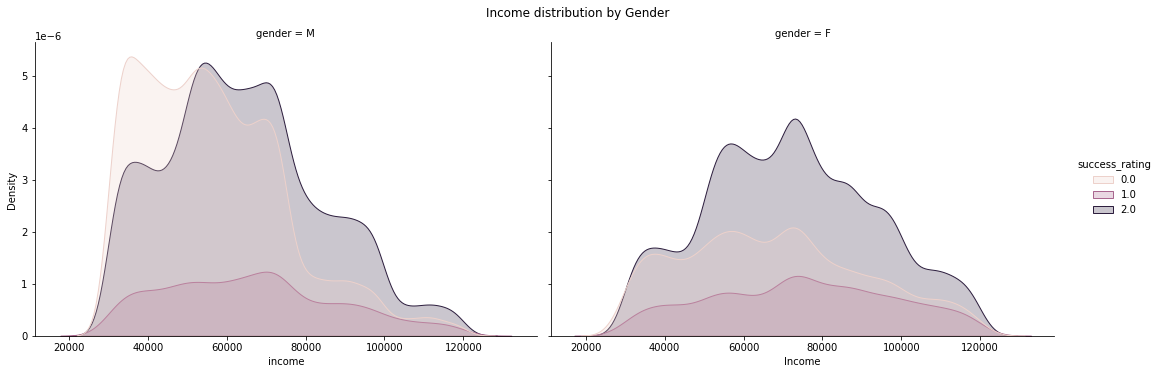

In [73]:
g = sns.displot(x='income', data=df,col='gender', hue='success_rating', kind='kde', fill=True, color = sns.color_palette('bright')[0:3],aspect=1.5)
g.fig.suptitle('Income distribution by Gender', y=1.03)
plt.xlabel('Income')
plt.show()

Overall the salary range for both genders are similar. However more male customers in the low income level (<40k), and less male customers in the high income lever(>100K) than female customers.

Data Modeling

Once completing the exploratary data analysis, now is the time build a machine learning model that predicts whether or not someone will respond to an offer. The result could be a successful offer (rating 2), a unviewed successful offer (rating 1) and an unsuccessful offer (rating 0).

1. Feature Engineering

In [74]:
#prepare a dataset to build the model.
df_model = df.copy()
df_model = df_model.drop(['person','offer_id','time'],axis=1)

In [75]:
df_model.head()

,index,success_rating,transaction amount,reward,difficulty,duration,offer_type,email,mobile,social,web,gender,age,became_member_on,income
0,0,2.0,22.16,0,0,3,informational,1,1,1,0,M,33,20170421,72000.0
1,3,2.0,0.00,0,0,4,informational,1,1,0,1,M,33,20170421,72000.0
2,5,1.0,8.57,5,5,5,bogo,1,1,1,1,M,33,20170421,72000.0
3,9,1.0,27.67,2,10,10,discount,1,1,1,1,M,33,20170421,72000.0
4,14,0.0,69.20,2,10,7,discount,1,1,0,1,M,33,20170421,72000.0


In [76]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65585 entries, 0 to 65584
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               65585 non-null  int64  
 1   success_rating      65585 non-null  float64
 2   transaction amount  65585 non-null  float64
 3   reward              65585 non-null  int64  
 4   difficulty          65585 non-null  int64  
 5   duration            65585 non-null  int64  
 6   offer_type          65585 non-null  object 
 7   email               65585 non-null  int64  
 8   mobile              65585 non-null  int64  
 9   social              65585 non-null  int64  
 10  web                 65585 non-null  int64  
 11  gender              65585 non-null  object 
 12  age                 65585 non-null  int64  
 13  became_member_on    65585 non-null  int64  
 14  income              65585 non-null  float64
dtypes: float64(3), int64(10), object(2)
memory usage: 10.

In [77]:
categorical_col = list(df_model.select_dtypes(include = ['object', 'category']).columns)
categorical_col 

['offer_type', 'gender']

In [78]:
numerical_col = list(df_model.select_dtypes(include = ['int', 'float']).columns)

In [79]:
numerical_col

['index',
 'success_rating',
 'transaction amount',
 'reward',
 'difficulty',
 'duration',
 'email',
 'mobile',
 'social',
 'web',
 'age',
 'became_member_on',
 'income']

In [80]:
numerical_col = ['transaction amount','reward','difficulty','duration','age', 'income']

In [82]:
for feature in categorical_col:
    col_dummy = pd.get_dummies(df_model[feature], dummy_na=False, prefix=feature)
    df_model = df_model.drop(columns=feature)
    df_model  = pd.concat([df_model,col_dummy],axis=1)

In [83]:
scaler = MinMaxScaler()
np_scaler = scaler.fit_transform(df_model[numerical_col])
df_scale = pd.DataFrame(np_scaler, columns=numerical_col)
df_model = df_model.drop(columns=numerical_col)
df_model  = pd.concat([df_model,df_scale],axis=1)


In [84]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65585 entries, 0 to 65584
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     65585 non-null  int64  
 1   success_rating            65585 non-null  float64
 2   email                     65585 non-null  int64  
 3   mobile                    65585 non-null  int64  
 4   social                    65585 non-null  int64  
 5   web                       65585 non-null  int64  
 6   became_member_on          65585 non-null  int64  
 7   offer_type_bogo           65585 non-null  uint8  
 8   offer_type_discount       65585 non-null  uint8  
 9   offer_type_informational  65585 non-null  uint8  
 10  gender_F                  65585 non-null  uint8  
 11  gender_M                  65585 non-null  uint8  
 12  transaction amount        65585 non-null  float64
 13  reward                    65585 non-null  float64
 14  diffic

In [85]:
df_model

,index,success_rating,email,mobile,social,web,became_member_on,offer_type_bogo,offer_type_discount,offer_type_informational,gender_F,gender_M,transaction amount,reward,difficulty,duration,age,income
0,0,2.0,1,1,1,0,20170421,0,0,1,0,1,0.019494,0.0,0.00,0.000000,0.180723,0.466667
1,3,2.0,1,1,0,1,20170421,0,0,1,0,1,0.000000,0.0,0.00,0.142857,0.180723,0.466667
2,5,1.0,1,1,1,1,20170421,1,0,0,0,1,0.007539,0.5,0.25,0.285714,0.180723,0.466667
3,9,1.0,1,1,1,1,20170421,0,1,0,0,1,0.024341,0.2,0.50,1.000000,0.180723,0.466667
4,14,0.0,1,1,0,1,20170421,0,1,0,0,1,0.060874,0.2,0.50,0.571429,0.180723,0.466667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65580,231812,0.0,1,1,1,1,20180328,1,0,0,1,0,0.002692,1.0,0.50,0.285714,0.518072,0.111111
65581,279260,2.0,1,1,1,1,20171013,1,0,0,1,0,0.019371,1.0,0.50,0.285714,0.855422,0.811111
65582,292864,2.0,1,1,1,1,20160730,1,0,0,0,1,0.029117,1.0,0.50,0.285714,0.843373,0.900000
65583,292869,2.0,1,1,1,1,20160730,1,0,0,0,1,0.764458,1.0,0.50,0.285714,0.843373,0.900000


2. Create train and test data sets.

In [86]:
X = df_model.drop(columns='success_rating')
y = df_model['success_rating']

In [87]:
X_train, X_test,  y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

3. Build a randomforest model.

In [ ]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
report = classification_report(y_test,y_pred)

In [ ]:
report

'              precision    recall  f1-score   support\n\n         0.0       0.76      0.77      0.77      7541\n         1.0       0.49      0.31      0.38      2670\n         2.0       0.74      0.81      0.77      9740\n\n    accuracy                           0.73     19951\n   macro avg       0.66      0.63      0.64     19951\nweighted avg       0.72      0.73      0.72     19951\n'

4. Tuning hyperparameters.

In [ ]:
param_grid={
            'max_depth' : [5,10,None],
            'min_samples_split': [2, 5, 10],
            'n_estimators': [10, 50, 100]
            }
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5,)
grid_search.fit(X, y)
grid_search.best_params_

{'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}

In [ ]:
model2 = RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=100)
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)

In [ ]:
report2 = classification_report(y_test,y_pred2)
report2

'              precision    recall  f1-score   support\n\n         0.0       0.75      0.81      0.78      7541\n         1.0       0.57      0.22      0.31      2670\n         2.0       0.74      0.83      0.79      9740\n\n    accuracy                           0.74     19951\n   macro avg       0.69      0.62      0.63     19951\nweighted avg       0.73      0.74      0.72     19951\n'